# Comparison of the mappings

This notebook aims to analyse the difference of the two mappings: rbmap and ghmap.

We will:
1. Compare the feature set between the two mappings on the complete dataset and on each type of contributor (human or bot).
2. Analyse the misclassifications made by the models (bimbis with ghmap and bimbaseline with rbmap) and how the features are modified between the two mappings for these misclassified contributors.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ghmap_features = pd.read_csv('../../resources/data/github/new-ghmap_features.csv')
ghmap_features['mapping'] = 'ghmap'
rbmap_features = pd.read_csv('../../resources/data/github/new-rbmap_features.csv')
rbmap_features['mapping'] = 'rbmap'

all_features = pd.concat([ghmap_features, rbmap_features], ignore_index=True)

print(f"Number of unique contributors: {len(ghmap_features)}")
display(all_features.head())

Number of unique contributors: 1872


,contributor,dataset,label,NA,NT,NR,NOR,ORR,NAR_mean,NAR_median,...,DCA_median,DCA_std,DCA_gini,DCA_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,mapping
0,kaczmarj,train,Human,23,9,9,7,0.778,2.556,1.0,...,3.275,136.697,0.809,43.009,70.712,8.895,145.195,0.779,59.305,ghmap
1,plasmapy-requirements-bot[bot],train,Bot,27,3,1,1,1.000,27.000,27.0,...,59.522,79.168,0.530,167.998,65.739,0.001,76.555,0.596,167.987,ghmap
2,accesslint[bot],train,Bot,90,1,27,27,1.000,3.333,2.0,...,6.711,19.571,0.634,14.347,NaN,NaN,0.000,0.000,NaN,ghmap
3,blueztestbot,train,Bot,148,6,4,2,0.500,37.000,29.5,...,0.154,8.694,0.848,0.948,3.946,0.011,10.351,0.836,1.310,ghmap
4,thundernest-bot,train,Bot,300,1,1,1,1.000,300.000,300.0,...,0.321,10.298,0.832,1.820,NaN,NaN,0.000,0.000,NaN,ghmap


In [3]:
def iqr(series):
    """Compute the interquartile range (IQR) of a series."""
    return series.quantile(0.75) - series.quantile(0.25)


# 1 - Comparison between ghmap and rbmap feature set

## 1.1 - On the complete dataset

Since the only difference between ghmap and rbmap is the way they group activities, we suspect features related to their numbers to be lower than with rbmap. Features related to time differences between activities should also be higher since some consecutive activities could now be grouped in one activity.

TLDR; The features are mostly the same between the two datasets. The only noticeable difference :
- The number of activities (NA) is slightly lower in the ghmap dataset => Some activities are now grouped together which reduce the overall number.
- The median number of types per repo (NTR_median) is higher in the rbmap dataset
- The median time difference between consecutive activities (DCA) is higher in the ghmap dataset (median)

### 1.1.1 - Number of activities
As expected, the number of activities (NA) is reduced with ghmap compared to rbmap. The median is lower (169 for rbmap and 144 for ghmap).

This is due to the fact that some activities are now grouped together in ghmap, which reduces the overall number of activities.

*note*: The number of activities can also increase due to the addition of grouping conditions in ghmap (validate_with)

Median number of activities for rbmap: 169.0, ghmap: 144.0


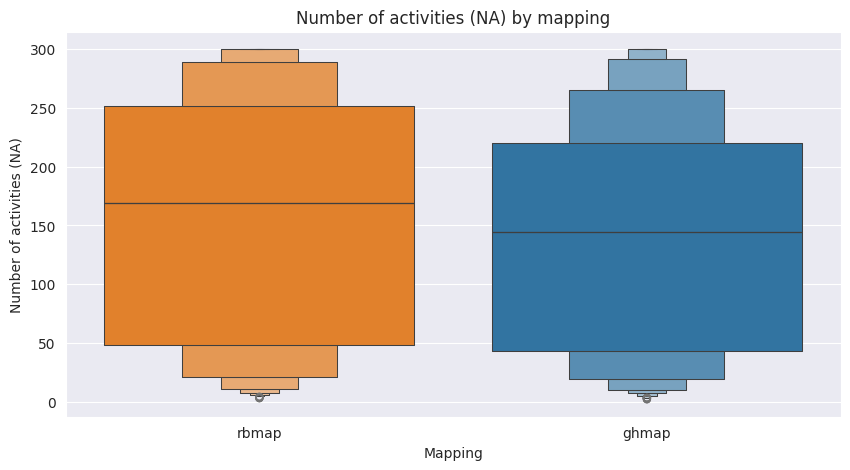

In [5]:
# Box plot to compare the activity of bots and humans
median_NA = all_features.groupby('mapping')['NA'].median()
print(f"Median number of activities for rbmap: {median_NA['rbmap']}, ghmap: {median_NA['ghmap']}")

plt.figure(figsize=(10, 5))
sns.boxenplot(x='mapping', y='NA', data=all_features, showfliers=True, order=['rbmap', 'ghmap'],
              palette=['#1f77b4', '#ff7f0e'], hue='mapping', legend=False)

plt.title('Number of activities (NA) by mapping')
plt.ylabel("Number of activities (NA)")
plt.xlabel("Mapping")
plt.show()

### 1.1.2 - Median Number of Types per Repo (NTR_median)
This grouping of activities also impacts significantly the median number of types per repo (NTR_median).

The median is slightly higher for rbmap (2) than for ghmap (1.5) but the distribution is more concentrated around lower values for ghmap.
For example, the 75% quantile is 3.5 for ghmap and 6 for rbmap which means that 75% of the repos have at most 3.5 types for ghmap and 6 for rbmap.

Median number of types per repo (NTR_median) for rbmap: 2.0, ghmap: 1.5
Max number of types per repo (NTR_median) for rbmap: 12.0, ghmap: 10.0
75% quantile for NTR_median of rbmap: 3.0, ghmap: 2.0


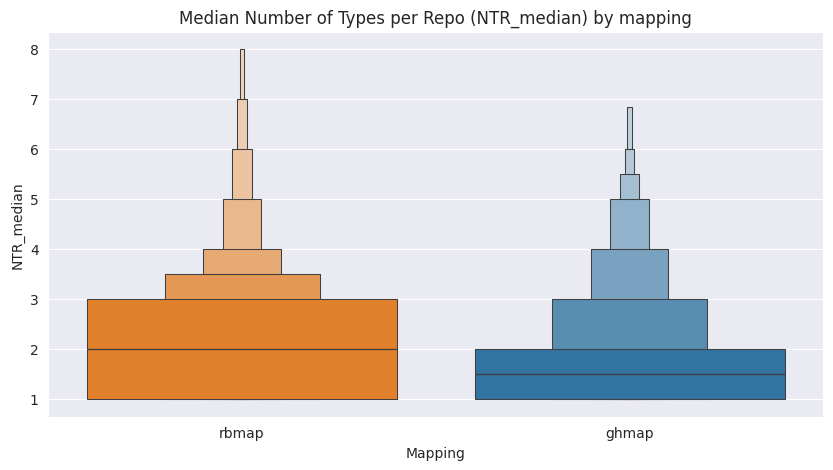

In [9]:
median_NTR_med = all_features.groupby('mapping')['NTR_median'].median()
max_NTR_med = all_features.groupby('mapping')['NTR_median'].max()
print(f"Median number of types per repo (NTR_median) for rbmap: {median_NTR_med['rbmap']}, ghmap: {median_NTR_med['ghmap']}")
print(f"Max number of types per repo (NTR_median) for rbmap: {max_NTR_med['rbmap']}, ghmap: {max_NTR_med['ghmap']}")
quantiles_NTR = all_features.groupby('mapping')['NTR_median'].quantile(0.75)
print(f"75% quantile for NTR_median of rbmap: {quantiles_NTR['rbmap']}, ghmap: {quantiles_NTR['ghmap']}")

plt.figure(figsize=(10, 5))
sns.boxenplot(x='mapping', y='NTR_median', data=all_features, showfliers=False
            , order=['rbmap', 'ghmap'],
              palette=['#1f77b4', '#ff7f0e'], hue='mapping', legend=False)

plt.title('Median Number of Types per Repo (NTR_median) by mapping')
plt.ylabel("NTR_median")
plt.xlabel("Mapping")
plt.show()

 ### 1.1.3 - Median Time difference between consecutive activities (DCA_median)
Since some activities are now grouped together in ghmap, the time difference between consecutive activities is thus higher.

In this case, the median of the feature for rbmap is 0.113 and for ghmap 0.21. This difference is significant but not as much as the maximum value which is 395 for rbmap and 720 for ghmap.

The 720 value is due to a bot (pyup-vuln-bot) that push 2 commits on the first of each month resulting. With rbmap, the events aren't grouped together resulting in a median of 0.001 (which is the time difference between the two commits). However, with ghmap the commits are grouped and thus the time difference is 720. This is a good example of how ghmap can modify the feature set.


Median time difference between consecutive activities (DCA_median) for rbmap: 0.113, ghmap: 0.21
75% quantile for DCA_median of rbmap: 0.9422499999999999, ghmap: 1.38475
Max time difference between consecutive activities (DCA_median) for rbmap: 395.099, ghmap: 720.002
User with max DCA_median for rbmap: przembot, ghmap: pyup-vuln-bot


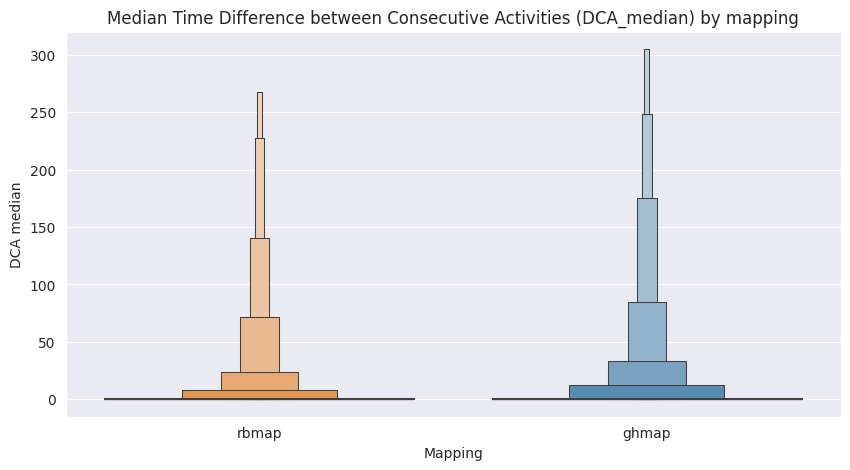

In [10]:
median_DCA = all_features.groupby('mapping')['DCA_median'].median()
print(f"Median time difference between consecutive activities (DCA_median) for rbmap: {median_DCA['rbmap']}, ghmap: {median_DCA['ghmap']}")
quantile_DCA = all_features.groupby('mapping')['DCA_median'].quantile(0.75)
print(f"75% quantile for DCA_median of rbmap: {quantile_DCA['rbmap']}, ghmap: {quantile_DCA['ghmap']}")
max_dca = all_features.groupby('mapping')['DCA_median'].max()
print(f"Max time difference between consecutive activities (DCA_median) for rbmap: {max_dca['rbmap']}, ghmap: {max_dca['ghmap']}")

max_user = all_features.groupby('mapping')['DCA_median'].idxmax()
print(f"User with max DCA_median for rbmap: {all_features.loc[max_user['rbmap'], 'contributor']}, ghmap: {all_features.loc[max_user['ghmap'], 'contributor']}")

plt.figure(figsize=(10, 5))
sns.boxenplot(x='mapping', y='DCA_median', data=all_features, showfliers=False, order=['rbmap', 'ghmap'],
              palette=['#1f77b4', '#ff7f0e'], hue='mapping', legend=False)

plt.title('Median Time Difference between Consecutive Activities (DCA_median) by mapping')
plt.ylabel("DCA median")
plt.xlabel("Mapping")
plt.show()

### 1.1.4 - Appendices - All plots

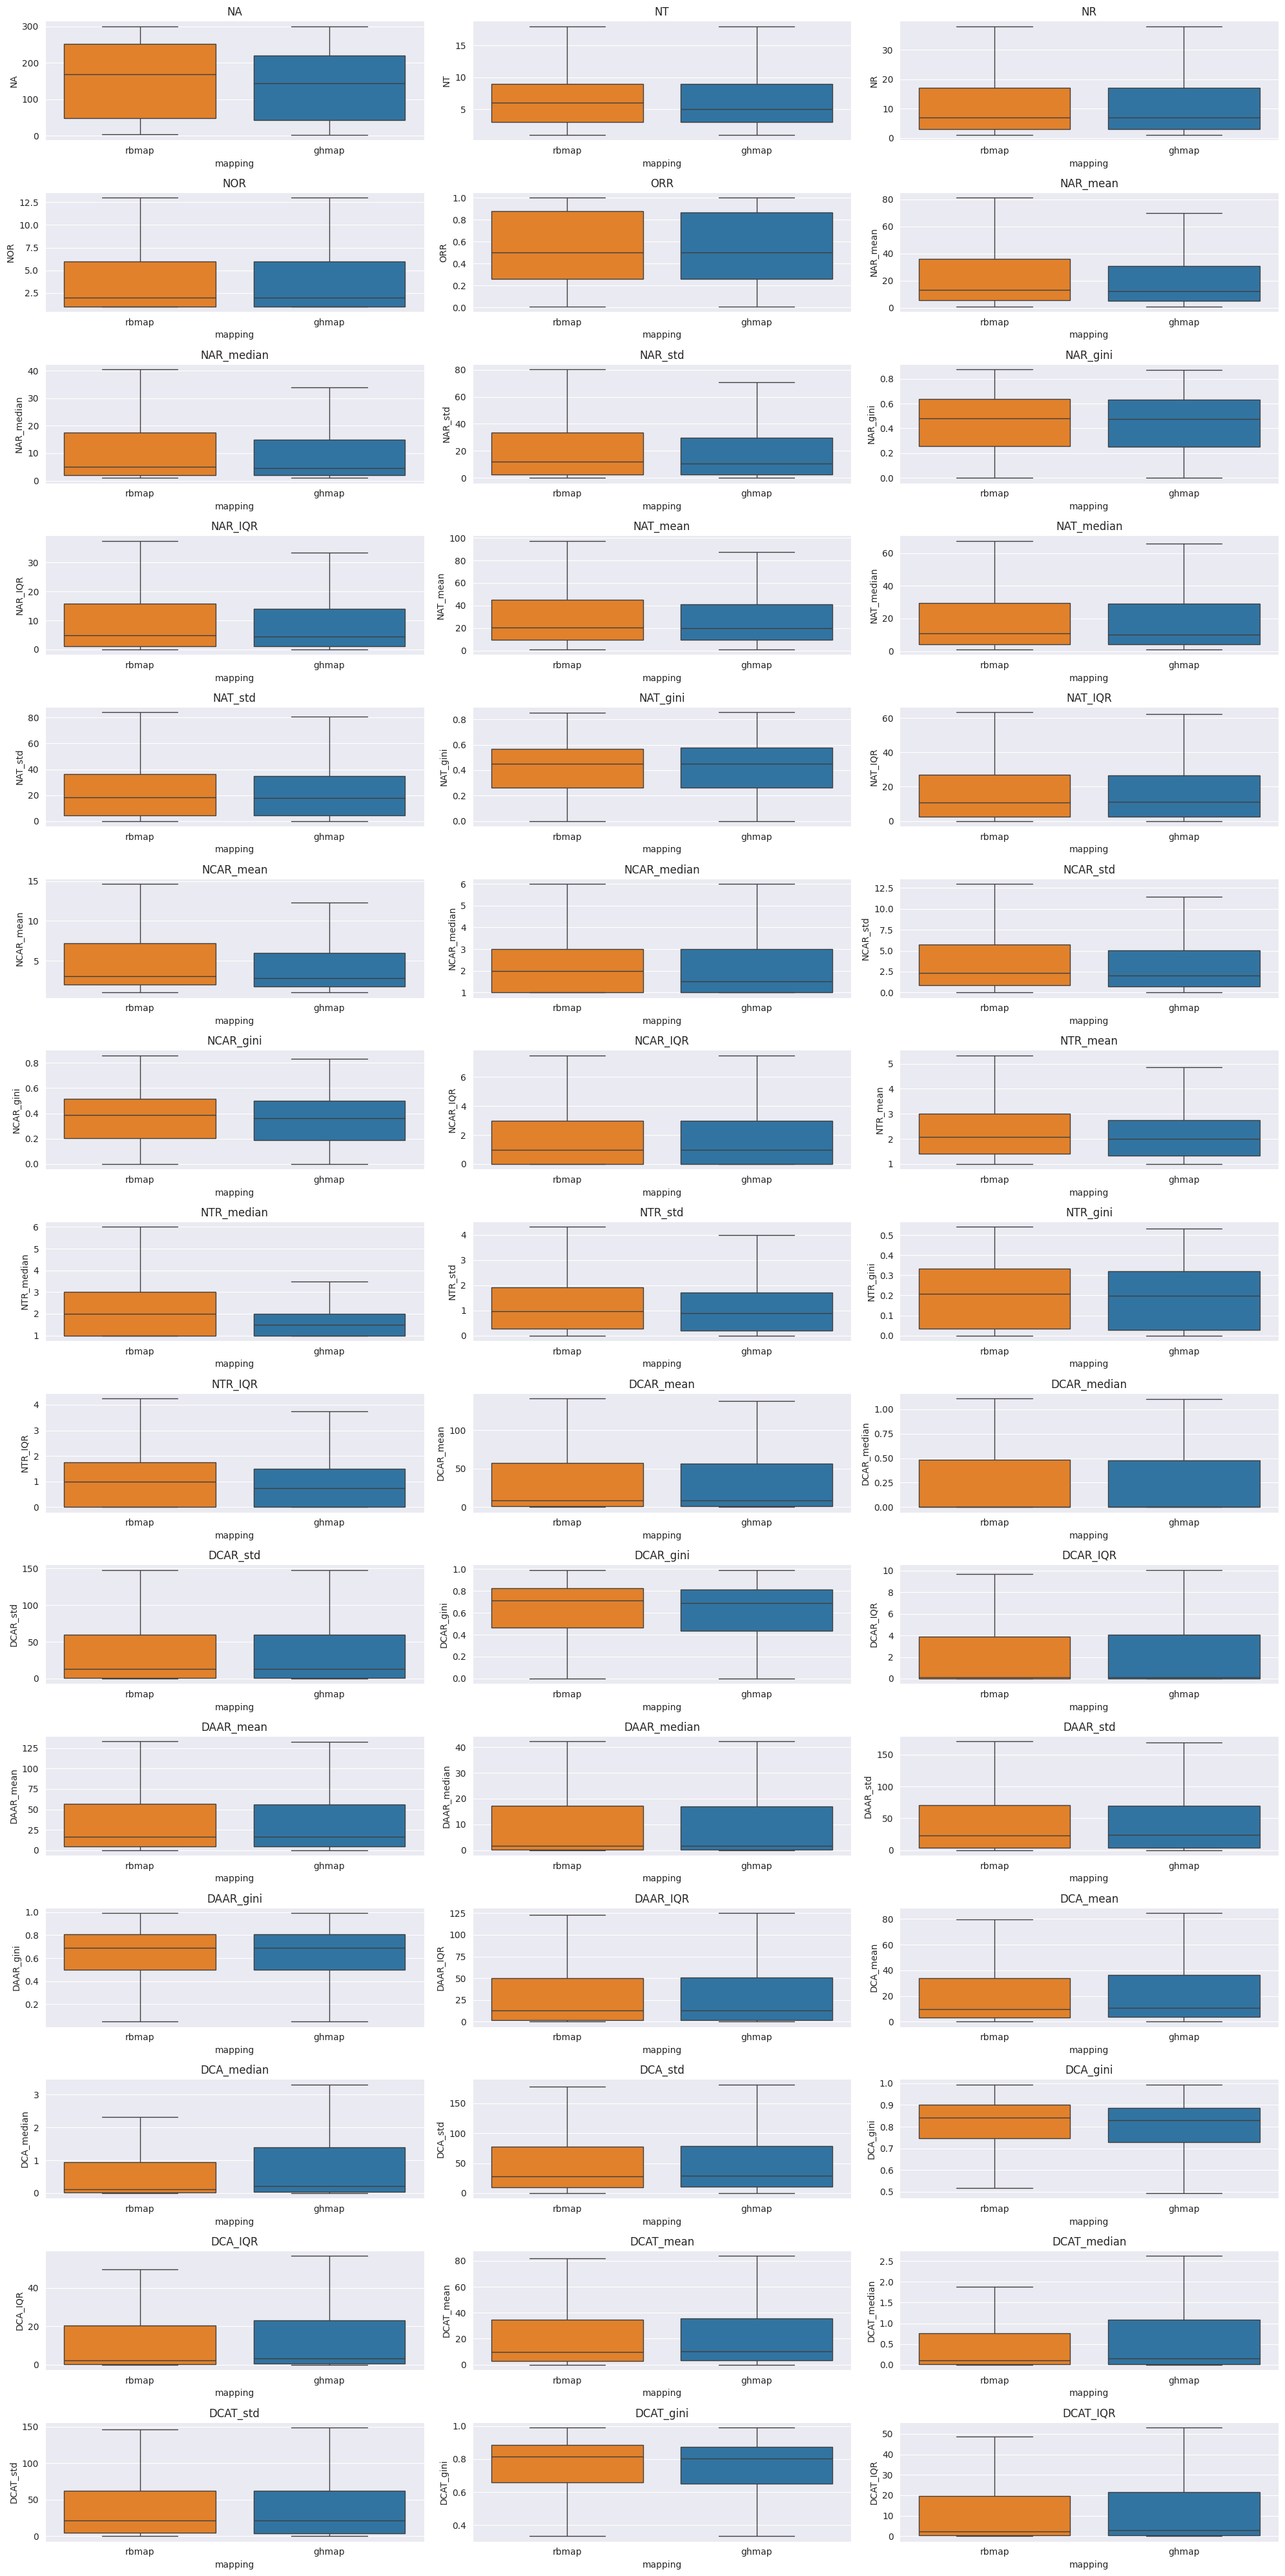

In [12]:
fig, axes = plt.subplots(15, 3, figsize=(20, 40))
for i, col in enumerate(rbmap_features.columns[3:-1]):
    sns.boxplot(x='mapping', y=col, data=all_features, ax=axes[i//3, i%3], showfliers=False, order=['rbmap', 'ghmap'], palette=['#1f77b4', '#ff7f0e'], hue='mapping', legend=False)
    axes[i//3, i%3].set_title(col)
plt.tight_layout()
plt.show()

## 1.2 - Comparison of the feature set for each type of contributor

The goal is to analyse if one type (human of bot) is more impacted by the modification of the mapping than the other with some features.

### 1.2.1 - Number of activity types (NT)
Humans seems to be more impacted by the modification of the mapping than bots with the number of activity types (NT).

Concretely, we have ~70% of the bots without any modification of their number of activity types (NT) but only ~36% of the humans.
And for the bots, the median nor the IQR has changed between the two mappings.

In [13]:
median_NT_label = all_features.groupby(['mapping', 'label'])['NT'].median()
print(f" [BOT] Median number of activity types (NT) for rbmap: {median_NT_label['rbmap', 'Bot']}, ghmap: {median_NT_label['ghmap', 'Bot']}")
print(f"[HUMAN] Median number of activity types (NT) for rbmap: {median_NT_label['rbmap', 'Human']}, ghmap: {median_NT_label['ghmap', 'Human']}")
IQR_NT_label = all_features.groupby(['mapping', 'label'])['NT'].apply(iqr)
print(f" [BOT] IQR number of activity types (NT) for rbmap: {IQR_NT_label['rbmap', 'Bot']}, ghmap: {IQR_NT_label['ghmap', 'Bot']}")
print(f"[HUMAN] IQR number of activity types (NT) for rbmap: {IQR_NT_label['rbmap', 'Human']}, ghmap: {IQR_NT_label['ghmap', 'Human']}")
max_NT_label = all_features.groupby(['mapping', 'label'])['NT'].max()
print(f" [BOT] Max number of activity types (NT) for rbmap: {max_NT_label['rbmap', 'Bot']}, ghmap: {max_NT_label['ghmap', 'Bot']}")
print(f"[HUMAN] Max number of activity types (NT) for rbmap: {max_NT_label['rbmap', 'Human']}, ghmap: {max_NT_label['ghmap', 'Human']}")


import matplotlib.pyplot as plt
import seaborn as sns

# Plot for bots
plt.figure(figsize=(10, 8))
sns.boxenplot(
    x='mapping',
    y='NT',
    data=all_features[all_features['label'] == 'Bot'],
    showfliers=False,
    order=['rbmap', 'ghmap'],
    hue='mapping',
    palette=['#1f77b4', '#ff7f0e']
)
plt.xlabel('')
plt.ylabel("# types d'activités (NT)", fontsize=30)
plt.xticks(ticks=[0, 1], labels=['rbmap', 'ghmap'], fontsize=30)
plt.yticks(fontsize=30)
plt.savefig("../figures/mapping_label_NT_bots.pdf", bbox_inches='tight')
plt.close()

# Plot for humans
plt.figure(figsize=(10, 8))
sns.boxenplot(
    x='mapping',
    y='NT',
    data=all_features[all_features['label'] == 'Human'],
    showfliers=False,
    order=['rbmap', 'ghmap'],
    hue='mapping',
    palette=['#1f77b4', '#ff7f0e']
)
plt.xlabel('')
plt.ylabel("# types d'activités (NT)", fontsize=30)
plt.xticks(ticks=[0, 1], labels=['rbmap', 'ghmap'], fontsize=30)
plt.yticks(fontsize=30)
plt.savefig("../figures/mapping_label_NT_humans.pdf", bbox_inches='tight')
plt.close()



 [BOT] Median number of activity types (NT) for rbmap: 3.0, ghmap: 3.0
[HUMAN] Median number of activity types (NT) for rbmap: 9.0, ghmap: 8.0
 [BOT] IQR number of activity types (NT) for rbmap: 3.0, ghmap: 3.0
[HUMAN] IQR number of activity types (NT) for rbmap: 6.0, ghmap: 5.0
 [BOT] Max number of activity types (NT) for rbmap: 11, ghmap: 11
[HUMAN] Max number of activity types (NT) for rbmap: 19, ghmap: 18


In [14]:
bots = all_features[all_features['label'] == 'Bot']
bots_subset = bots[['contributor', 'mapping', 'NT']]

# Pivot the Dataframe to have contributors as index and mappings as columns
bots_pivot = bots_subset.pivot(index='contributor', columns='mapping', values='NT')

bots_pivot['NT_diff'] = bots_pivot['rbmap'] - bots_pivot['ghmap']
diff_bots = bots_pivot[bots_pivot['NT_diff'] != 0]

print(f"Number of bots with a different NT between rbmap and ghmap: {len(diff_bots)} ou of {len(bots_pivot)} ({len(diff_bots)/len(bots_pivot)*100:.2f}%)")

# Do the same for humans
humans = all_features[all_features['label'] == 'Human']
humans_subset = humans[['contributor', 'mapping', 'NT']]
humans_pivot = humans_subset.pivot(index='contributor', columns='mapping', values='NT')
humans_pivot['NT_diff'] = humans_pivot['rbmap'] - humans_pivot['ghmap']
diff_humans = humans_pivot[humans_pivot['NT_diff'] != 0]

print(f"Number of humans with a different NT between rbmap and ghmap: {len(diff_humans)} out of {len(humans_pivot)} ({len(diff_humans)/len(humans_pivot)*100:.2f}%)")

Number of bots with a different NT between rbmap and ghmap: 267 ou of 917 (29.12%)
Number of humans with a different NT between rbmap and ghmap: 607 out of 955 (63.56%)


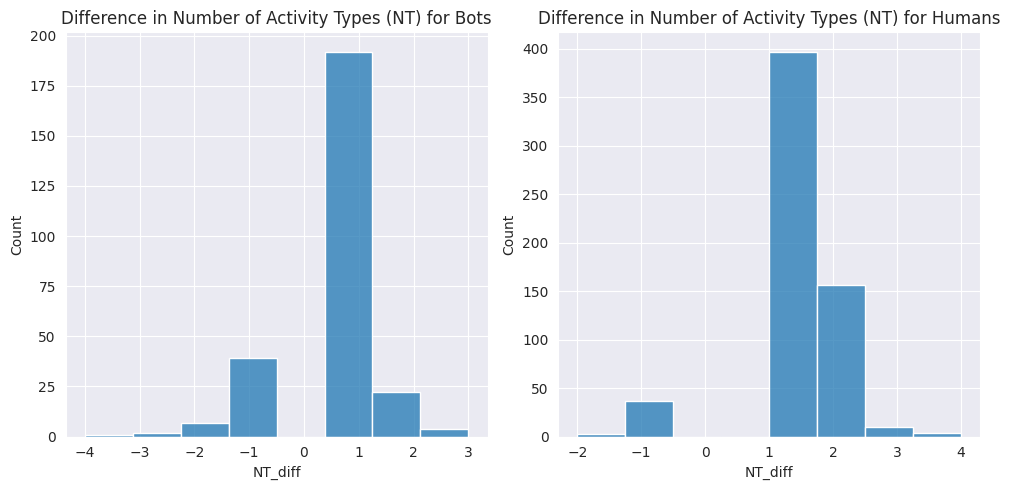

In [17]:
# Plot both histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(diff_bots['NT_diff'], ax=axes[0], kde=False, bins=8)
axes[0].set_title('Difference in Number of Activity Types (NT) for Bots')
sns.histplot(diff_humans['NT_diff'], ax=axes[1], kde=False, bins=8)
axes[1].set_title('Difference in Number of Activity Types (NT) for Humans')
plt.tight_layout()
plt.show()

### 1.2.2 - Mean Number of Activities per Type (NAT_mean)

Small difference but the bots seems to be more impacted for the mean number of activities per type (NAT_mean).

This is possibly due to the fact that some consecutive activities are now grouped together in ghmap. (if multiple pushes are performed in a short time, they are grouped in a single activity)

 [BOT] Median Number of Activities per Type (NAT_mean) for rbmap: 43.8, ghmap: 39.5
[HUMAN] Median Number of Activities per Type (NAT_mean) for rbmap: 13.909, ghmap: 13.5
 [BOT] IQR Number of Activities per Type (NAT_mean) for rbmap: 53.0, ghmap: 49.75
[HUMAN] IQR Number of Activities per Type (NAT_mean) for rbmap: 15.098999999999997, ghmap: 14.209000000000001


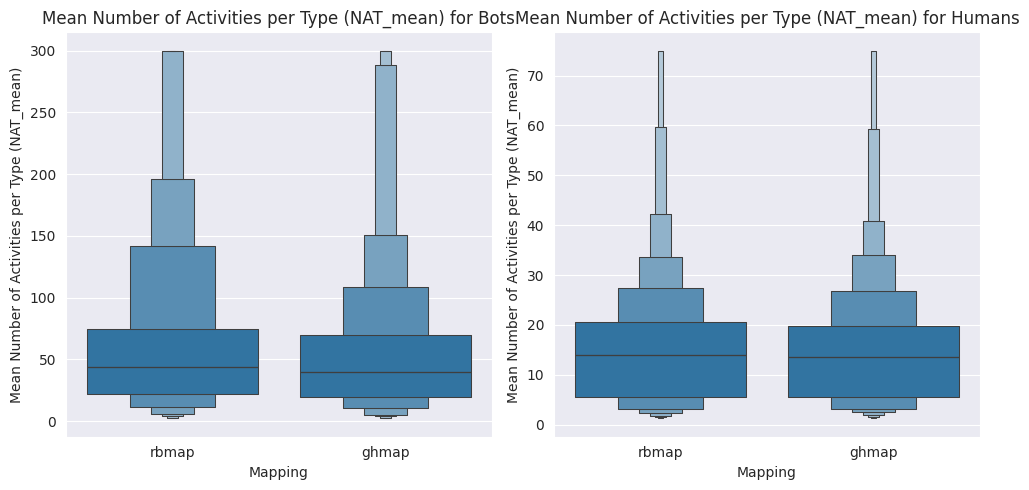

In [19]:
median_NAT_mean_label = all_features.groupby(['mapping', 'label'])['NAT_mean'].median()
print(f" [BOT] Median Number of Activities per Type (NAT_mean) for rbmap: {median_NAT_mean_label['rbmap', 'Bot']}, ghmap: {median_NAT_mean_label['ghmap', 'Bot']}")
print(f"[HUMAN] Median Number of Activities per Type (NAT_mean) for rbmap: {median_NAT_mean_label['rbmap', 'Human']}, ghmap: {median_NAT_mean_label['ghmap', 'Human']}")
IQR_NAT_mean_label = all_features.groupby(['mapping', 'label'])['NAT_mean'].apply(iqr)
print(f" [BOT] IQR Number of Activities per Type (NAT_mean) for rbmap: {IQR_NAT_mean_label['rbmap', 'Bot']}, ghmap: {IQR_NAT_mean_label['ghmap', 'Bot']}")
print(f"[HUMAN] IQR Number of Activities per Type (NAT_mean) for rbmap: {IQR_NAT_mean_label['rbmap', 'Human']}, ghmap: {IQR_NAT_mean_label['ghmap', 'Human']}")


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxenplot(x='mapping', y='NAT_mean', data=all_features[all_features['label'] == 'Bot'], ax=axes[0], showfliers=False, order=['rbmap', 'ghmap'])
axes[0].set_xlabel('Mapping')
axes[0].set_ylabel('Mean Number of Activities per Type (NAT_mean)')
axes[0].set_title('Mean Number of Activities per Type (NAT_mean) for Bots')
sns.boxenplot(x='mapping', y='NAT_mean', data=all_features[all_features['label'] == 'Human'], ax=axes[1], showfliers=False, order=['rbmap', 'ghmap'])
axes[1].set_xlabel('Mapping')
axes[1].set_ylabel('Mean Number of Activities per Type (NAT_mean)')
axes[1].set_title('Mean Number of Activities per Type (NAT_mean) for Humans')
plt.tight_layout()
plt.show()

### 1.2.x - Appendices - All plots

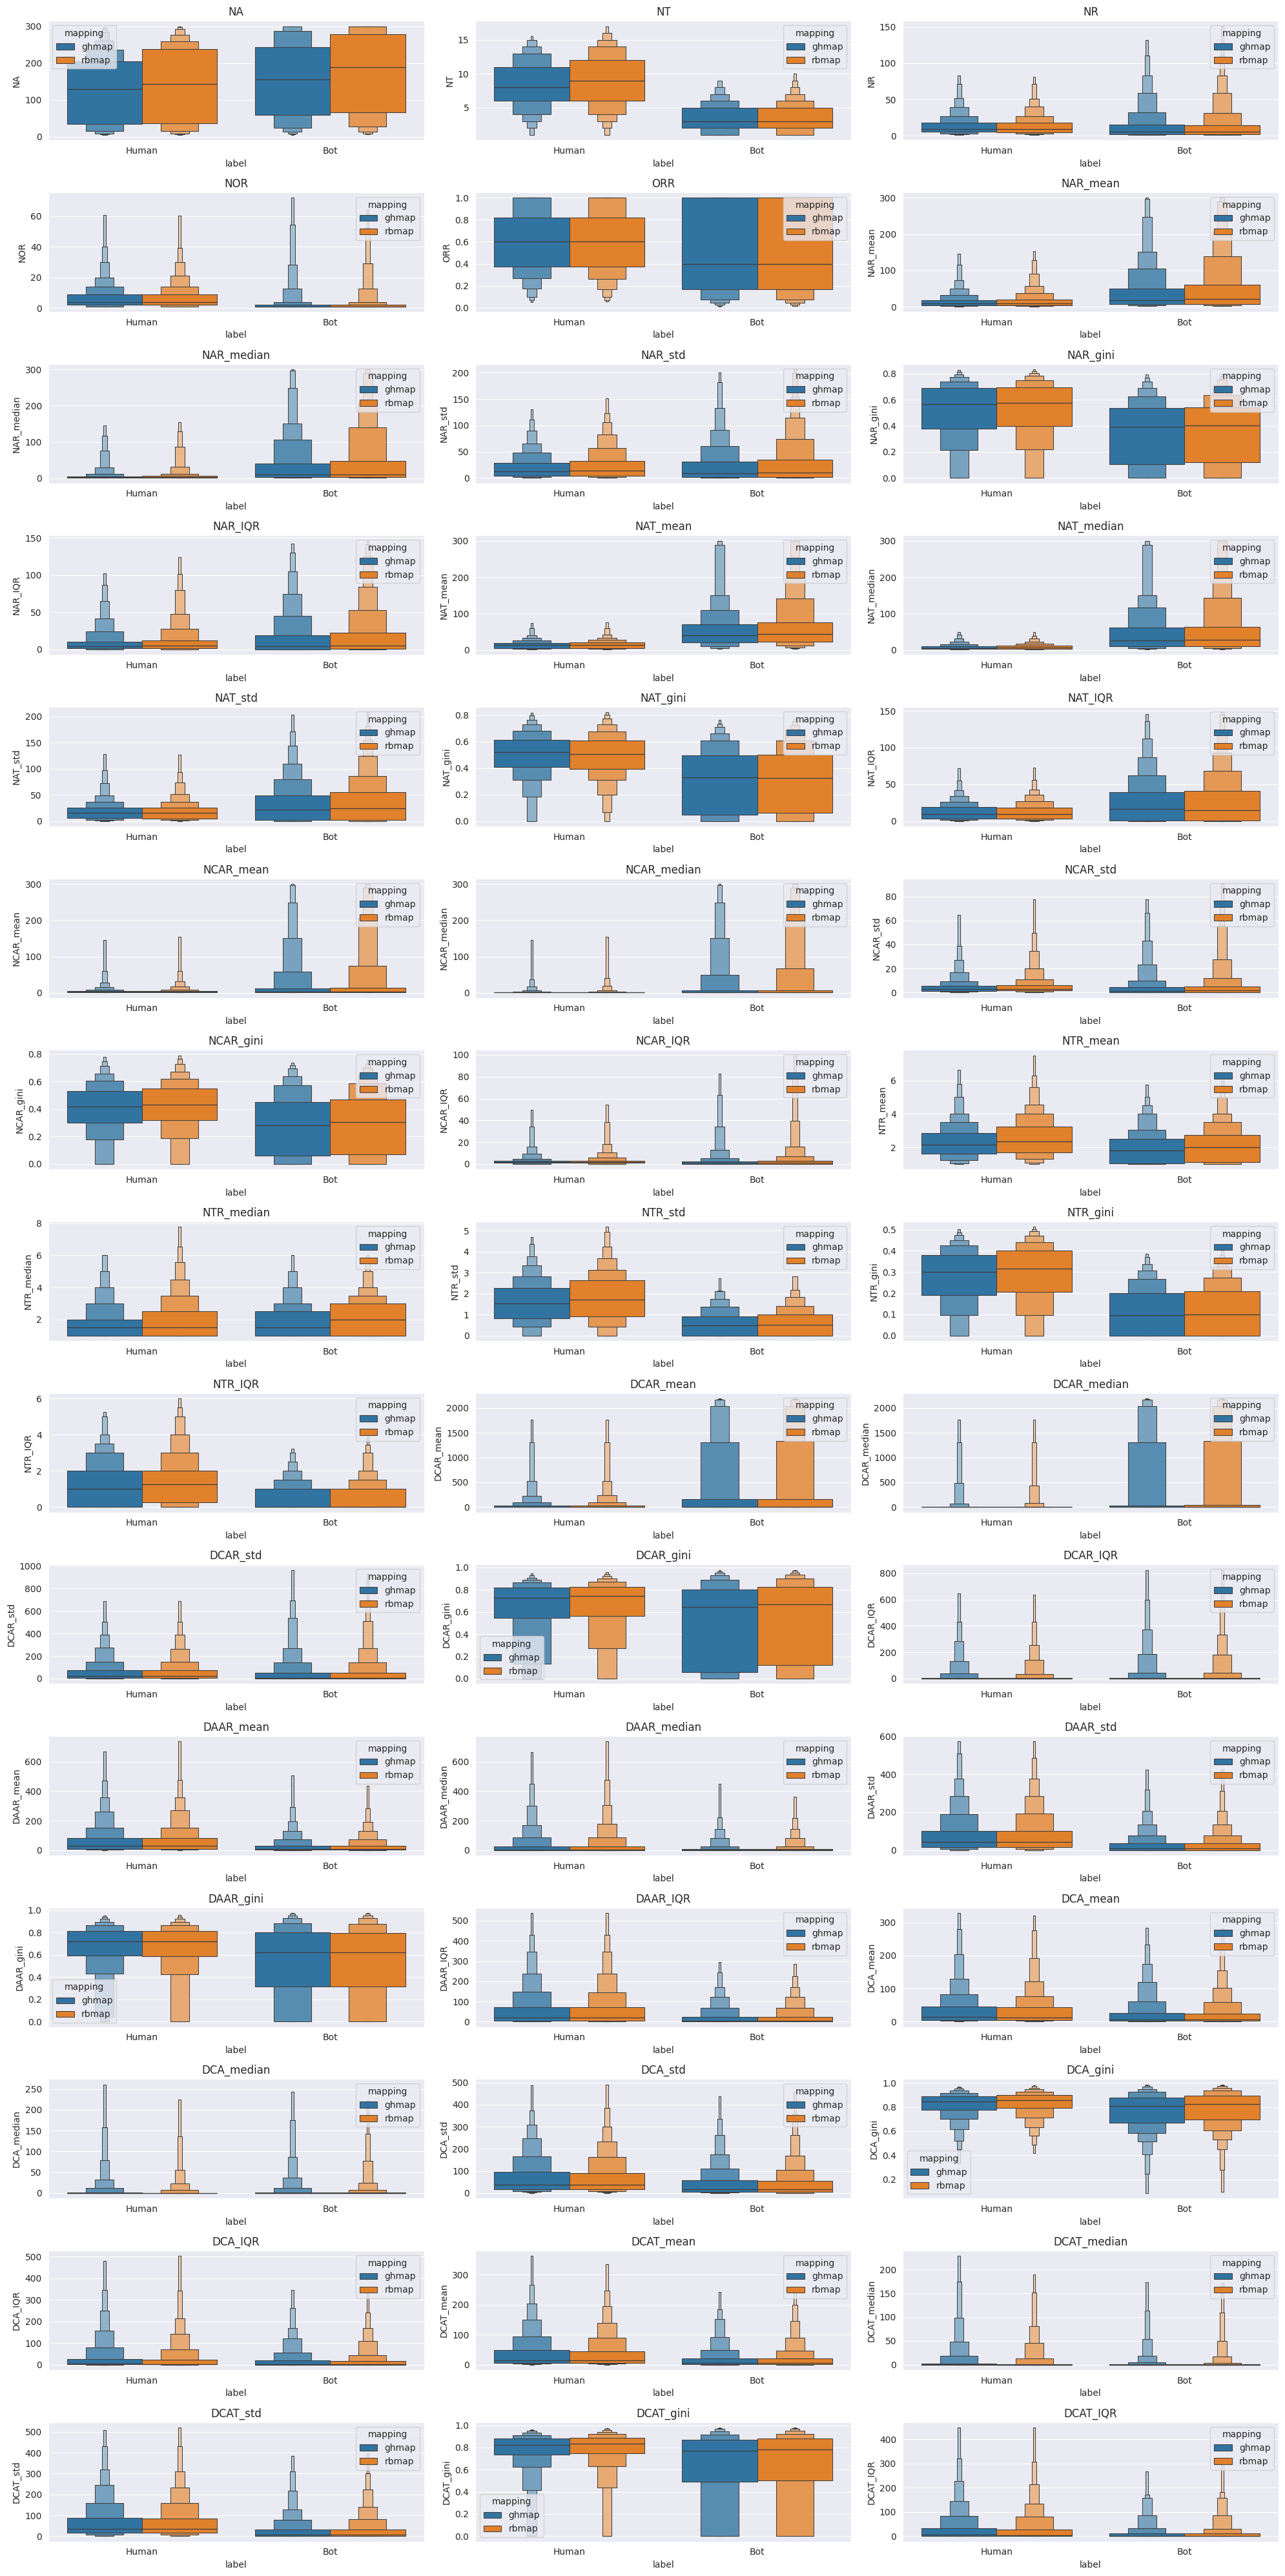

In [20]:
fig, axes = plt.subplots(15, 3, figsize=(20, 40))
for i, col in enumerate(rbmap_features.columns[3:-1]):
    sns.boxenplot(x='label', y=col, hue='mapping', data=all_features, ax=axes[i//3, i%3], showfliers=False, order=['Human', 'Bot'], palette=['#1f77b4', '#ff7f0e'], legend=True)
    axes[i//3, i%3].set_title(col)
plt.tight_layout()
plt.show()

# 2 - Analyse misclassifications

In [21]:
rbmap_mis = pd.read_csv('../../resources/evals/github-predictions/bimbaseline-rbmap_predictions.csv')
true_account = rbmap_mis[['contributor', 'true_bot']].drop_duplicates()
n_accounts = len(true_account)

rbmap_mis = rbmap_mis[rbmap_mis['true_bot'] != rbmap_mis['predicted_bot']]
print(f"BIMBASELINE (with rbmap) has misclassified {len(rbmap_mis)} account out of {len(true_account)}")
print(f"With {len(rbmap_mis[rbmap_mis['true_bot'] == 'Bot'])} bots out of {len(true_account[true_account['true_bot'] == 'Bot'])} ")
print(f"With {len(rbmap_mis[rbmap_mis['true_bot'] == 'Human'])} humans out of {len(true_account[true_account['true_bot'] == 'Human'])} ")

bimbis_mis = pd.read_csv('../../resources/evals/github-predictions/bimbis-ghmap_predictions.csv')
bimbis_mis = bimbis_mis[bimbis_mis['true_bot'] != bimbis_mis['predicted_bot']]
print(f"BIMBIS (with ghmap) has misclassified {len(bimbis_mis)} account out of {n_accounts}")
print(f"With {len(bimbis_mis[bimbis_mis['true_bot'] == 'Bot'])} bots out of {len(true_account[true_account['true_bot'] == 'Bot'])} ")
print(f"With {len(bimbis_mis[bimbis_mis['true_bot'] == 'Human'])} humans out of {len(true_account[true_account['true_bot'] == 'Human'])} ")


BIMBASELINE (with rbmap) has misclassified 76 account out of 763
With 41 bots out of 376 
With 35 humans out of 387 
BIMBIS (with ghmap) has misclassified 81 account out of 763
With 45 bots out of 376 
With 36 humans out of 387 


## 2.1 - Analyse main features differences on misclassifications

The idea is to analyze how the main features are modified between rbmap and ghmap for the contributors misclassified by at least one model.

### 2.1.1 - Table construction
We will create a table with the following columns
- `contributor`: Name of the user
- `true_bot`: True label of the contributor (Bot or Human)
- `diff_NA`: Difference of NA between rbmap and ghmap (ghmap - rbmap)
- `diff_NT`: Difference of NT (Number of different types)
- `diff_NOR`: Difference of NOR (Number of Owner of Repositories)
- `diff_DCAT_median`: Difference of DCAT_median (median number of difference between consecutive activities of different types)
- `diff_NAT_median0`: Difference of NAT_median (median number of the number of activities by type)
- `diff_NAT_mean`: Difference of NAT
- `predicted_bot_rbmap`: Value predicted by bimbaseline with rbmap
- `predicted_bot_ghmap`: Value predicted by bimbis with ghmap
- `Same prediction`: 1 if both model predicted the same label, 0 otherwise.

In [22]:
main_features = ['NA', 'NT', 'NOR', 'DCAT_median', 'NAT_median', 'NAT_mean']

rbmap = pd.read_csv('../../resources/evals/github-predictions/bimbaseline-rbmap_predictions.csv')
ghmap = pd.read_csv('../../resources/evals/github-predictions/bimbis-ghmap_predictions.csv')

# Find misclassified for each model
rbmap_misclassified = rbmap[rbmap['true_bot'] != rbmap['predicted_bot']]
ghmap_misclassified = ghmap[ghmap['true_bot'] != ghmap['predicted_bot']]
misclassified_contributors = pd.unique(
    pd.concat([rbmap_misclassified['contributor'], ghmap_misclassified['contributor']])
)

In [23]:
filtered_features = all_features[all_features['contributor'].isin(misclassified_contributors)]

rbmap_features = filtered_features[filtered_features['mapping'] == 'rbmap']
ghmap_features = filtered_features[filtered_features['mapping'] == 'ghmap']

merged = pd.merge(rbmap_features, ghmap_features, on='contributor', suffixes=('_rbmap', '_ghmap'))

diff_features = pd.DataFrame()
diff_features['contributor'] = merged['contributor']
for feature in main_features:
    diff_features[feature + '_diff'] = merged[feature + '_ghmap'] - merged[feature + '_rbmap']

In [24]:
diff_features = diff_features.merge(
    ghmap[['contributor', 'true_bot', 'predicted_bot']].rename(columns={'predicted_bot': 'predicted_bot_ghmap'}),
    on='contributor',
    how='left'
)

diff_features = diff_features.merge(
    rbmap[['contributor', 'predicted_bot']].rename(columns={'predicted_bot': 'predicted_bot_rbmap'}),
    on='contributor',
    how='left'
)
# Add column "same prediction
diff_features['Same prediction'] = diff_features.apply(
    lambda row: 1 if row['predicted_bot_ghmap'] == row['predicted_bot_rbmap'] else 0,
    axis=1
)
diff_features = diff_features.round(4)

display(diff_features)

,contributor,NA_diff,NT_diff,NOR_diff,DCAT_median_diff,NAT_median_diff,NAT_mean_diff,true_bot,predicted_bot_ghmap,predicted_bot_rbmap,Same prediction
0,apiology,-49,-1,0,0.014,-0.5,-1.367,Human,Bot,Bot,1
1,genie-jnosql,-2,0,0,0.000,-1.0,-0.500,Bot,Human,Human,1
2,mreiferson,0,-1,0,0.000,1.0,0.357,Human,Bot,Bot,1
3,bgraef,2,-1,0,-0.002,14.5,7.800,Human,Bot,Bot,1
4,brunozoric,-24,-2,0,0.031,3.0,7.542,Human,Bot,Human,0
...,...,...,...,...,...,...,...,...,...,...,...
88,aarongable,-14,-4,0,-0.004,0.0,13.377,Human,Bot,Human,0
89,vks,0,-1,0,45.039,0.0,0.583,Human,Bot,Bot,1
90,matzkoh,-15,-1,0,442.796,-7.0,-2.333,Human,Bot,Bot,1
91,asyncapi-bot,-48,-2,0,0.050,1.5,0.083,Bot,Human,Human,1


In [25]:
diff_features.to_csv('../../resources/evals/github-predictions/analysis/misclassified_feature_differences.csv', index=False)

### 2.1.2 - Misclassification due to low activity
For the misclassifications made by both models, we can find some examples of contributors with a low number of activities.

For example, `rakutentech-danger-bot` has 8 only activities. In this case, the model has not enough information to correctly detect that it is a bot.
For this example, we can see that modification of the mapping has no impact on him and all the features are the same. This explains why both models have the same prediction.

We can also find examples where ghmap reduce the number of activities leading to a misclassification by bimbis.

For example, `icingabot` had 6 activities with rbmap but has only 3 activites with ghmap. It was correctly classified as a bot by bimbaseline but bimbis misclassified.

In [26]:
# Low number of activities : rakutentech-danger-bot
rakuten_features = all_features[all_features['contributor'] == 'rakutentech-danger-bot']
display(rakuten_features)

,contributor,dataset,label,NA,NT,NR,NOR,ORR,NAR_mean,NAR_median,...,DCA_median,DCA_std,DCA_gini,DCA_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,mapping
1741,rakutentech-danger-bot,test,Bot,8,2,2,1,0.5,4.0,4.0,...,234.892,250.835,0.461,383.396,13.359,13.359,6.402,0.169,4.527,ghmap
3613,rakutentech-danger-bot,test,Bot,8,2,2,1,0.5,4.0,4.0,...,234.892,250.835,0.461,383.396,13.359,13.359,6.402,0.169,4.527,rbmap


This is a typical example where the mapping does not modify the features.

However, sometimes ghmap also reduce the number of activites leading to a misclassification.

In [27]:
display(diff_features[diff_features['contributor'] == 'icingabot'])

,contributor,NA_diff,NT_diff,NOR_diff,DCAT_median_diff,NAT_median_diff,NAT_mean_diff,true_bot,predicted_bot_ghmap,predicted_bot_rbmap,Same prediction
84,icingabot,-3,-1,0,NaN,0.0,0.0,Bot,Human,Bot,0


In [28]:
display(all_features[all_features['contributor'] == 'icingabot'])

,contributor,dataset,label,NA,NT,NR,NOR,ORR,NAR_mean,NAR_median,...,DCA_median,DCA_std,DCA_gini,DCA_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,mapping
1790,icingabot,test,Bot,3,1,1,1,1.0,3.0,3.0,...,180.001,186.676,0.367,132.000,NaN,NaN,0.0,0.000,NaN,ghmap
3662,icingabot,test,Bot,6,2,1,1,1.0,6.0,6.0,...,0.000,135.765,0.683,48.001,78.0,0.0,156.0,0.667,78.0,rbmap


### 2.1.3 - ghmap leading to misclassification

We can see many examples where ghmap modify the features (such as increasing DCAT_median or reducing NAT) which leads to a misclassification by bimbis but not by bimbaseline.
> Reminder:  Bot have a lower DCAT_median than humans and a higher NAT_median than humans

For example, with `dotnet-issue-labeler[bot]`, its DCAT_median has increased of 13.881 and its NAT_median and NAT_mean have decreased of 4.5. Hence, bimbis misclassified it as human.


In [29]:
# Display the contributors that are misclassified by bimbis but not by bimbaseline
ghmap_misclassified = diff_features[
    (diff_features['predicted_bot_ghmap'] != diff_features['true_bot']) &
    (diff_features['predicted_bot_rbmap'] == diff_features['true_bot'])
]
display(ghmap_misclassified)

,contributor,NA_diff,NT_diff,NOR_diff,DCAT_median_diff,NAT_median_diff,NAT_mean_diff,true_bot,predicted_bot_ghmap,predicted_bot_rbmap,Same prediction
4,brunozoric,-24,-2,0,0.031,3.0,7.542,Human,Bot,Human,0
6,centeredgebot[bot],-27,-2,0,4.406,-1.0,-1.533,Bot,Human,Bot,0
15,dragonwasrobot,-9,-1,1,40.893,8.5,7.167,Human,Bot,Human,0
20,robotis-will,0,-1,0,0.000,0.0,0.433,Human,Bot,Human,0
25,itholic,6,-1,0,-0.021,2.5,6.881,Human,Bot,Human,0
26,rmconsole6-wk,-25,-1,0,0.498,-1.5,-2.833,Bot,Human,Bot,0
29,sgolebiewski-intel,-1,-2,0,0.022,7.0,12.167,Human,Bot,Human,0
36,poggit-bot,-42,0,-1,9.835,-21.0,-21.000,Bot,Human,Bot,0
42,awesomerobot,-48,-2,0,0.139,0.5,2.667,Human,Bot,Human,0
49,arduino-ci-script-bot,5,0,0,0.000,1.0,0.834,Bot,Human,Bot,0


### 2.1.4 - Better classification with ghmap

With ghmap, some consecutive activities are now correctly grouped together which leads to a better classification of some contributors.

For example, with `leleuj`, its number of activities has decreased of 90, leading to a reduction of the number of activity per type (NAT_mean) of 11.250. Hence, bimbis correctly classified it as human while bimbaseline misclassified it as a bot.

In [30]:
# Display the contributors that are misclassified by bimbis but not by bimbaseline
rbmap_misclassified = diff_features[
    (diff_features['predicted_bot_ghmap'] == diff_features['true_bot']) &
    (diff_features['predicted_bot_rbmap'] != diff_features['true_bot'])
]
display(rbmap_misclassified)

,contributor,NA_diff,NT_diff,NOR_diff,DCAT_median_diff,NAT_median_diff,NAT_mean_diff,true_bot,predicted_bot_ghmap,predicted_bot_rbmap,Same prediction
10,geoperez,-36,1,0,0.130,-17.5,-10.667,Human,Human,Bot,0
13,enoch85,-133,1,1,-0.009,-1.0,-21.982,Human,Human,Bot,0
16,staging[bot],6,-1,1,NaN,7.5,7.500,Bot,Bot,Human,0
17,pr-scheduler[bot],-13,-1,0,2.628,12.5,3.667,Bot,Bot,Human,0
24,jwinzer,0,0,0,0.000,0.0,0.000,Human,Human,Bot,0
27,cdagaming,-222,0,0,0.000,0.0,-44.400,Human,Human,Bot,0
37,stan-buildbot,-4,-2,0,0.575,7.0,10.000,Bot,Bot,Human,0
44,ankoh,-42,-1,0,2.478,-12.0,-3.900,Human,Human,Bot,0
53,leleuj,-90,0,0,0.007,3.5,-11.250,Human,Human,Bot,0
72,yazz,7,0,1,0.034,0.5,1.750,Human,Human,Bot,0


### 2.1.5 - Labelling error
In the table from last section, we can see a contributor [cdagaming](https://github.com/cdagaming) with a reduction of the number of activities of 222.

After investigating, we found that this contributor is actually a mirror of a GitLab contributor. [cdagaming-gitlab](https://gitlab.com/CDAGaming/).
When we fetched the data, the actual commits were performed on GitLab and then synced to GitHub all at once. In its GitHub profile, we see the correct timestamp of the commits but the activities returned by the API are the ones from the sync.

A sample of the public events of this contributor available at the time we fetched the data is available [here](https://gist.github.com/MrRose765/cb78f663c7b19d0051849677e09a6d8f).



In [31]:
display(all_features[all_features['contributor'] == 'cdagaming'])

,contributor,dataset,label,NA,NT,NR,NOR,ORR,NAR_mean,NAR_median,...,DCA_median,DCA_std,DCA_gini,DCA_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,mapping
1342,cdagaming,test,Human,76,5,8,2,0.25,9.50,4.0,...,0.158,54.513,0.907,0.452,17.147,1.11,28.227,0.694,25.197,ghmap
3214,cdagaming,test,Human,298,5,8,2,0.25,37.25,4.0,...,0.000,28.140,0.927,0.001,17.147,1.11,28.227,0.694,25.197,rbmap
